# Device-independent certification
> Device-independent certification through randomized measurements. We illustrate how to compute the purity and overlap of states across different backends. 

We illustrate how to leverage the random measurement procedure to compare states that can be prepared in entirely different platforms. Such procedure allows us to certify the state preparation process in quantum devices by computing the overlap, defined as $\text{Tr}\left[\rho_0\rho_1\right]$, between the prepared unknown state $\rho_1$ with other reference known state $\rho_0$, regadless of the quantum device nature (superconducting qubits, trapped ions, etc.). 

In this example, we compare an analytic noiseless simulation of a GHZ state with an analogous preparation of the same state in a noisy device. Using qiskit, we can prepare the GHZ state with a rather simple circuit and then execute it with different backends. 

In [ ]:
#hide
from qiskit import QuantumCircuit
from qiskit.opflow import CircuitStateFn
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error

from fisherman.overlap.all import *

import numpy as np
import matplotlib.pyplot as plt

## State preparation

The GHZ state of $N$ qubits is defined as $$|\text{GHZ}\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle^{\otimes^N} + |1\rangle^{\otimes^N}\right).$$

In order to keep simulation times as low as possible while still showcasing some relevant applications, we take the 3-qubit GHZ state $\frac{1}{\sqrt{2}}\left(|000\rangle + |111\rangle\right)$ for this example. 

We define our own little function that creates the circuit to prepare the $|GHZ\rangle$ state.

In [ ]:
def ghz_circuit(n_qubits):
    "Returns a `QuantumCircuit` that prepares the GHZ state for `n_qubits`."
    qc = QuantumCircuit(n_qubits)
    qc.h(0)
    for i in range(n_qubits-1): qc.cx(i, i+1)
    return qc

For our initial testing, we will also add measurements at the end. This will allow us to empirically characterize the state preparation process by looking at the measurement counts. 

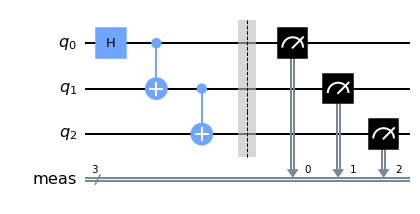

In [ ]:
n_qubits = 3
qc = ghz_circuit(n_qubits)
qc.measure_all()
qc.draw('mpl')

## Exact simulation

First, we simulate the circuit without any kind of noise. This assumes that all operations are perfect and that there are no errors neither in the gates nor the measurements. 

In [ ]:
sim = QasmSimulator()
qi_ideal = QuantumInstance(sim)

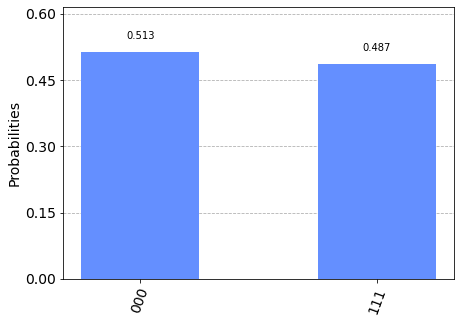

In [ ]:
counts = qi_ideal.execute(qc).get_counts()
plot_histogram(counts)

In this exact simulation, only two states are sampled, the $|000\rangle$ and the $|111\rangle$, with equal probability. 

## Noisy execution

Let us now perform the same simulation in a more realistic scenario in which we simulate a real quantum computer. In this case, we have taken the Vigo quantum device. We emphasize that it is not required to simulate the device and we can run the same code choosing an actual real quantum computer as backend.

In this case, there are several errors of various natures that may occur during the execution of our quantum circuit that will affect both the state preparation and measurement. Furthermore, every circuit must be adapted to the topology of the quantum device, which may incur further additional operations (prone to errors) to, for instance, perform multi-qubit gates such as the CNOT `cx` of our circuit. The combined effect of all the stochastic errors is what we call the noise of the device. 

In [ ]:
sim_vigo = QasmSimulator.from_backend(FakeVigo())
qi_vigo = QuantumInstance(sim_vigo)

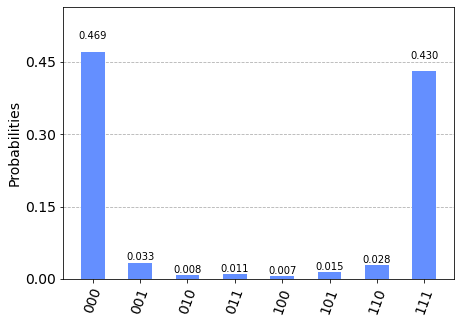

In [ ]:
counts = qi_vigo.execute(qc).get_counts()
plot_histogram(counts)

In the histogram above we see that we now sample all possible states, in contrast with what we have previously observed in the noiseless simulation. Even though the $|000\rangle$ and $|111\rangle$ states are sampled with a much higher probability than the others, the actual state is no longer the $|\text{GHZ}\rangle$ that we have observed in the simulation.  

Hence, the development of techniques to assess the quality of state preparation in real devices if of utmost importance to ensure the proper development of quantum technologies. One way of doing so is by obtaining a measure of the distance between the prepared state and the exact state. We show, below, how to obtain the overlap between states prepared on arbitrarily different platforms, including simulated states, by performing a series of randomized measurements.

## Effect of noise

So far, we have seen the combined effect of noise in state preparation and measurement. In order to study the effect of noise, rather than taking the simulation of a real quantum computer, we will create our own tunnable noise model for the simulator. However, in quantum devices, noise comes in many different forms. To ease the analysis, we restrict ourselves to a specific kind of errors: two-qubit depolarizing errors happening on the control not gates `cx` independently of the qubits, which allows us to study the noise effect in state preparation with ideal measurements.   

In [ ]:
noise_model = NoiseModel()
noise_level = 0.1
error = depolarizing_error(noise_level, 2)
noise_model.add_all_qubit_quantum_error(error, ['cx'])
noise_model

<NoiseModel on ['cx']>

We now have a `NoiseModel` that we can tune with the `noise_level`$\in[0, 1]$ variable, which controls the amount of depolarization suffered at each gate. To obtain our noisy simulator, we simply join our `NoiseModel` together with the simulator backend in a `QuantumInstance`. 

In [ ]:
qi_noisy = QuantumInstance(sim, noise_model=noise_model)

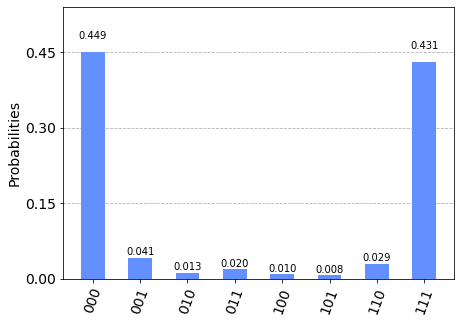

In [ ]:
counts = qi_noisy.execute(qc).get_counts()
plot_histogram(counts)

The resulting state is no longer a pure state, but rather a mixed state. The purity of a state is defined as the overlap with itself $\text{Tr}\left[\rho^2\right]\in\left[\frac{1}{N_H},1\right]$, where $N_H$ is the dimension of the Hilbert space, and it is maximal when the state is pure. Actually, the overlap between pure states can be expressed as $|\langle\psi|\phi\rangle|^2$ for two pure states $\psi, \ \phi$ and it is straightforward to see that the purity of a pure state $\psi$ is $|\langle\psi|\psi\rangle|^2=1$.

We can use the `fisherman` library to seamlessly compute the purity of the prepared states with the noisy and ideal simulators through various methods. To do so, we simply need to provide the circuit that prepares the state as a `StateFn` (or `CircuitStateFn`) and the backend to run it. 

In [ ]:
state = CircuitStateFn(ghz_circuit(n_qubits))

In [ ]:
purity_ideal_rnd = randomized_measurement_overlap(state, backend=qi_ideal)
purity_ideal_swap = swap_test_overlap(state, backend=qi_ideal)
purity_noisy_rnd = randomized_measurement_overlap(state, backend=qi_noisy)
purity_noisy_swap = swap_test_overlap(state, backend=qi_noisy)

print(f"Purity ideal simulator through randomized measurements {purity_ideal_rnd:.3f} and swap test {purity_ideal_swap:.3f}")
print(f"Purity noisy simulator through randomized measurements {purity_noisy_rnd:.3f} and swap test {purity_noisy_swap:.3f}")

Purity ideal simulator through randomized measurements 0.996 and swap test 1.000
Purity noisy simulator through randomized measurements 0.743 and swap test 0.711


As expected, the purity of the state prepared on a noisy device is lower than the state prepared on an ideal device, which is one.

> Note: Due to the random nature of the randomized measurement algorithm, the result may vary differing from one within a small margin (even being larger than one) in the case of the pure state.  

Let us see the effect of noise intensity in the purity of the prepared state. 

To ease the readability of the code, we make a simple function to quickly create our noisy backends as we adjust the noise level.  

In [ ]:
def get_noisy_qi(noise_level=0.1, backend=None):
    "Creates a noise model with errors on `cx` gates according to the `noise_level`."
    backend = QasmSimulator() if backend is None else backend
    noise_model = NoiseModel()
    error = depolarizing_error(noise_level, 2)
    noise_model.add_all_qubit_quantum_error(error, ['cx'])
    return QuantumInstance(backend, noise_model=noise_model)

Let's compute the purity for various noise levels with the main three different methods in the package: randomized measurements, swap test and compute-uncompute. 

In [ ]:
noise_levels = np.linspace(0, 1, 21)
rnd_purities, swap_purities, cu_purities = [], [], []

for noise_level in noise_levels:
    qi = get_noisy_qi(noise_level)
    rnd_purities.append(randomized_measurement_overlap(state, backend=qi, n_rnd=300))
    swap_purities.append(swap_test_overlap(state, backend=qi))
    cu_purities.append(compute_uncompute_overlap(state, backend=qi))

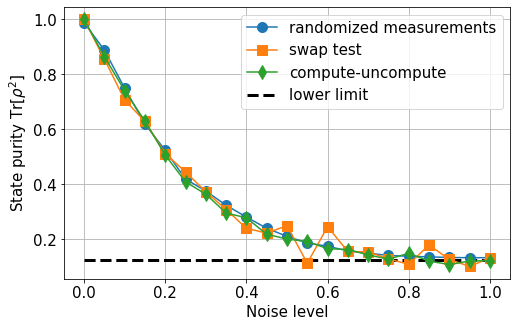

In [ ]:
#collapse_input
plt.figure(figsize=(8, 5))
plt.plot(noise_levels, rnd_purities, 'o-', ms=10, label='randomized measurements')
plt.plot(noise_levels, swap_purities, 's-', ms=10, label='swap test')
plt.plot(noise_levels, cu_purities, 'd-', ms=10, label='compute-uncompute')
plt.hlines(1/2**n_qubits, 0, 1, 'k', '--', linewidth=3, label='lower limit')
plt.grid()
plt.legend(fontsize=15)
plt.tick_params(labelsize=15)
plt.xlabel("Noise level", fontsize=15)
plt.ylabel(r"State purity Tr[$\rho^2$]", fontsize=15);

We observe that, without noise (`noise_level=0`), the purity of the prepared state is one and, as we increase the noise level, it decreases to its minimum possible obtainable value, as the state is completely depolarized. Notice that at `noise_level=1` the state is fully depolarized with every entangling gate. 

As a final remark, we find great agreement between all the methods with the swap test being slightly unstable at some points.  

> Important: It is very important that we set the optional parameter `local=True` (as per default) when calling `randomized_measurement_overlap`, as it will implement random single-qubit gates to perform the random measurements. When set to `False`, the algorithm uses global random unitaries instead, which require many multiple-qubit operations to be executed in a circuit. This massively amplifies the effect of noise in the circuit, as the circuit depth it dramatically increased, resulting into completely depolarized states from very low noise levels. Try it out and see!

## Overlap between states on different platforms

Now that we have a better understanding of the effect of noise in state preparation and we have got familiar with the concept of overlap and purity, let us find the overlap between states prepared in different platforms. As previously mentioned, this has great potential in the certification of quantum devices, as it allows us to assess the quality of state preparation and measurement of a quantum device by comparing it with a known reference. 

Given that the swap test and the compute-uncompute methods are based on circuits that contain both states at once, this cross-platform certification can only be performed via random measurements. In this method, we perform a series of random measurements, characterized by a set of random unitary matrices $U$ uniformly sampled from the Haar measure. This way, the probability $P_U(s)$ of measuring a given state $|s\rangle$ after a random unitary evolution $U$ of our initial state $\rho$ is $P(s) = \text{Tr}\left[U\rho U^\dagger|s\rangle\langle s|\right]$ and its expected value over all possible random measurements is $\langle P(s)\rangle=1/N_H$. 

By measuring higher moments of $P(s)$, $\langle P(s)^n\rangle$, we can infer the value of $\text{Tr}\left[\rho^n\right]$ (see [[1]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.110503) and [[2]](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.052323)). In particular, we can infer the purity of a state $\text{Tr}\left[\rho^2\right]$ from its second moment $\langle P(s)^2\rangle$ and, even more, this allows us to infer the overlap between two states $\rho_0, \ \rho_1$ from $\langle P_0(s)P_1(s)\rangle$. The only requirement is that the set of random measurements $U$ must the same for the two states. Hence, as long as we are able to find a way to properly define the random unitaries, we can find the overlap between quantum states of any arbitrary nature.

The function `device_independent_overlap` allows us to compute such cross-platform overlaps with ease. For instance, we can compute the overlap between our simulated $|GHZ\rangle$ state and the same state prepared in the (simulated) noisy backend.  

In [ ]:
backends = [qi_ideal, qi_noisy]

In [ ]:
cross_backend_overlap = device_independent_overlap(state, backends)
cross_backend_overlap

array([[0.98468652, 0.83525961],
       [0.83525961, 0.72293895]])

When we only provide a state and a list of backends, the function computes the overlap between all possible combinations of backends. Every row contains the overlap between the state in a given backend with the state simulated by all the backends (check the docs for more detailed explanations). Hence, in the first row, we have the purity of the state in the ideal simulation (should be one) and the overlap between this state and the noisy state. In the second row, we find the same cross-overlap and the purity of the noisy state (lower than one). 

This format comes in quite handy as all the purities are in the diagonal of the resulting `numpy.ndarray`.

In [ ]:
cross_backend_overlap.diagonal()

array([0.98468652, 0.72293895])

Let's repeat the same process as before and obtain the overlap between a state in an ideal simulation with states in increasingly noisy simulations. 

In [ ]:
backends = [get_noisy_qi(noise_level) for noise_level in noise_levels]
cross_backend_overlap = device_independent_overlap(state, backends)

overlap_ideal_noisy = cross_backend_overlap[0]
purities = cross_backend_overlap.diagonal()

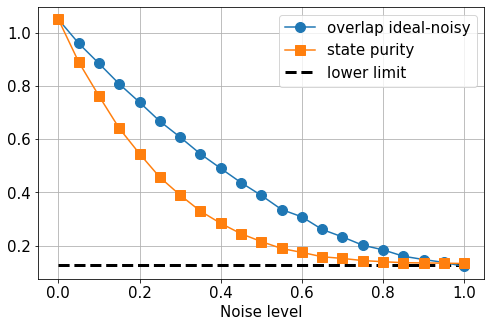

In [ ]:
#collapse_input
plt.figure(figsize=(8, 5))
plt.plot(noise_levels, overlap_ideal_noisy, 'o-', ms=10, label='overlap ideal-noisy')
plt.plot(noise_levels, purities, 's-', ms=10, label='state purity')
plt.hlines(1/2**n_qubits, 0, 1, 'k', '--', linewidth=3, label='lower limit')
plt.grid()
plt.legend(fontsize=15)
plt.tick_params(labelsize=15)
plt.xlabel("Noise level", fontsize=15);

The state purity decreases faster with noise than the overlap between the exact and the noisy states. 

This process allows us to compare states in any kind of device. We encourage you to try and benchmark the state preparation of different quantum computers following the same procedure!

## References
[1] S. J. van Enk and C. W. J. Beenakker, <a href="https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.110503"> Measuring $\text{Tr}\rho^n$ on single copies of $\rho$ using random measurements.</a> _PRL_ 108, 110503 (2012).

[2] A. Elben _et al._, <a href="https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.052323"> Statistical correlations between locally randomized measurements: A toolbox for probing entanglement in many-body quantum states.</a> _PRA_ 99, 052323 (2019).